<a href="https://colab.research.google.com/github/tkhabia/Leaf_infection_detection/blob/master/MINILEAVES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Getting things ready

In [ ]:
!pip install fastai2

     |████████████████████████████████| 194kB 2.6MB/s 


In [ ]:
# Some useful imports
import pandas as pd
import numpy as np
import fastai2
from fastai2.vision.all import *
from sklearn.metrics import log_loss as skll
from PIL import Image as PImage
import random
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-07-22 13:27:39--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.16, 130.117.252.12, 130.117.252.10, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 886 [text/plain]
Saving to: ‘all_classes.txt’

all_classes.txt     100%[===================>]     886  --.-KB/s    in 0s      

2020-07-22 13:27:40 (10.2 MB/s) - ‘all_classes.txt’ saved [886/886]



In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy

--2020-07-22 13:27:54--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.10, 130.117.252.16, 130.117.252.17, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33294464 (32M) [binary/octet-stream]
Saving to: ‘test-images.npy’

test-images.npy     100%[===================>]  31.75M  6.67MB/s    in 5.5s    

2020-07-22 13:28:00 (5.81 MB/s) - ‘test-images.npy’ saved [33294464/33294464]

--2020-07-22 13:28:06--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.16, 130.117.252.12, 130.117.252.11, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.16|:4

In [ ]:
!ls *.npy

test-images.npy  train-images.npy  train-labels.npy


# Loading Data

In [ ]:
train_labels = np.load('train-labels.npy')
train_labels.shape, train_labels[0]

((43466,), 7)

In [ ]:
train_ims = np.load('train-images.npy')
train_ims.shape, train_ims[0].shape

((43466, 32, 32, 3), (32, 32, 3))

In [ ]:
test_ims = np.load('test-images.npy')
test_ims.shape, test_ims[0].shape

((10838, 32, 32, 3), (32, 32, 3))

In [ ]:
ims = np.concatenate([train_ims, test_ims])
ims.shape

(54304, 32, 32, 3)

# Baseline Model

This is the important bit. We use custom get_x and get_y functions. get_x should return a numpy array of an image. Usually it will load an image from a file, resize and convert to an array. Here, we feed it an index (ID) and it simply grabs the pre-made array and returns it. For y, we get the corresponding label.

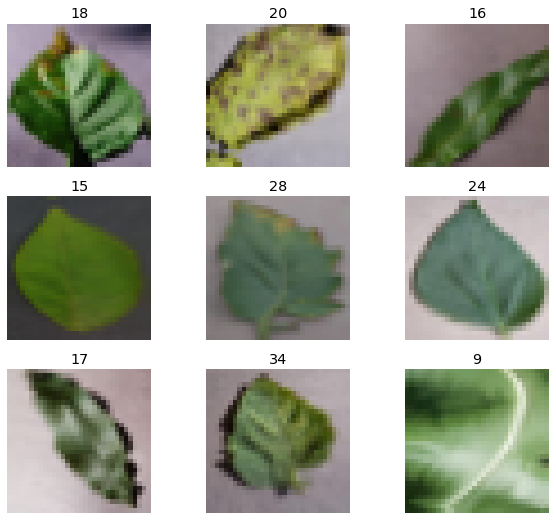

In [ ]:
# Get the image:
def get_x(ID):
  return ims[ID]

# And the label
def get_y(ID):
  return train_labels[ID]

# Get the list of Image IDS:
def get_im_ids(path):
  return range(len(train_ims))

# And build the datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_im_ids,
    get_x=get_x,
    get_y=get_y, 
    splitter=RandomSplitter(valid_pct=0.1),
    batch_tfms=aug_transforms(size=32)
)
dls = dblock.dataloaders(Path(''), bs=64)
dls.show_batch()
plt.savefig('al.png')

With the dataloaders created, making and training a model can be as simple as:

In [ ]:
# Create the learner
learn = cnn_learner(dls, resnet50, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.919519,0.558648,0.828348,01:37
1,0.539907,0.488755,0.850667,01:37
2,0.529064,0.479965,0.853889,01:38
3,0.601381,0.432135,0.861482,01:38
4,0.409602,0.358219,0.894616,01:38
5,0.499187,0.619046,0.816613,01:37
6,0.307786,0.417430,0.875978,01:37
7,0.274967,0.302189,0.907041,01:37
8,0.226158,0.198747,0.938104,01:37
9,0.197949,0.219084,0.926829,01:38


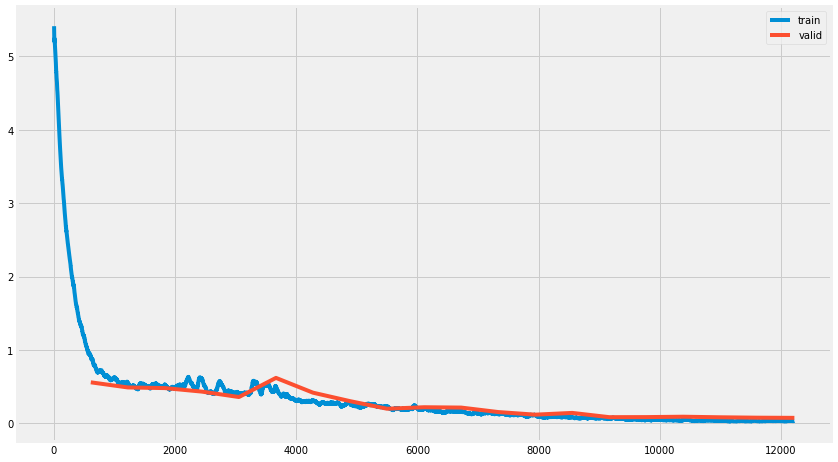

In [ ]:
plt.rcParams['figure.figsize'] = [13, 8]
learn.recorder.plot_loss()
plt.savefig('loss.png')

Now that we have a baseline model trained, we need to save predicitons for a submission.

In [ ]:
# Create a test dataloader and get predictions
idxs = [i + len(train_ims) for i in range(len(test_ims))]
tdl = learn.dls.test_dl(idxs)
test_preds, test_labels = learn.tta(dl=tdl) # Using test time augmentation. Replace tta with get_preds for simpler inference.

In [ ]:
# Get the predicted classes based on the probabilities
pred_classes = [int(np.argmax(t)) for t in test_preds]

In [ ]:
# Make a submission dataframe
sub = pd.DataFrame({
    'class_index':pred_classes
})
sub.head()

,class_index
0,37
1,30
2,34
3,30
4,6


In [ ]:
# Save and submit
sub.to_csv('submission.csv', index=False)
sub.to_csv('submission_baseline.csv', index=False)